# Creating an Interactive Visualizer
**Jessica Kong^ and Suhas Somnath***<br>
^University of Washington  
*National Center for Computational Sciences<br>
Oak Ridge National Laboratory  
9/5/2018

In this notebook, we will show how to create a visualizer that will facilitate **interactive data exploration**. In this particular example, we will create a visualizer that will help you interactively (using ``widgets``) determine the appropriate value of the parameter for an (Gaussian) image filtering function applied to an atomically resolved image. 

The primary purpose of this tutorial is to show that one can quickly set up an interactive visualizer. Specifics regarding image processing can be found in a [related notebook](./06_Image_Processing.ipynb). 

A couple points about widgets: 
* ``ipywidgets`` can be finicky and tend to work better on particular browsers and operating system combinations. So, if the interactive plots do not display properly, please try different browsers. Google's Chrome browser seems to work for most people.
* Widgets work best or only with ``% matplotlib notebook`` as opposed to ``%matplolib inline`` This is especially true if you have updated your packages to a recent version. Note that switching from ``inline`` to ``notebook`` would cause some of your plots to appear differently.

## Load necessary packages

In [1]:
# Numeric operations
import numpy as np
# Visualization / Plotting
from matplotlib import pyplot as plt
import skimage
if int(skimage.__version__.split('.')[1]) < 14:
    from warnings import warn
    warn('Your skimage version is: {} but the recommended version is 0.14.0.' 
         'Some features may not work if you do not have the latest version'.format(skimage.__version__))
from skimage.io import imread
from skimage import filters
import ipywidgets as widgets

# Ensure that images are rendered in this notebook:
%matplotlib inline

//anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Reading and normalizing the source image 
The most popular method to read images is using the ``skimage.io.imread()`` function. ``skimage.img_as_float`` is a very handy function that is often used to normalize the data to ``[0, 1]`` from the original datatype. Here, we normalize the image prior applying an FFT. 

Text(0.5,1,'Original image')

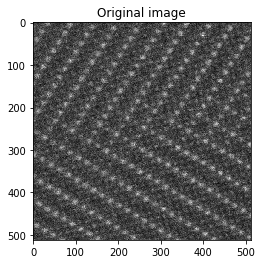

In [7]:
# Reading the image here:
stem_image = imread('./data/LLTO_800.tif')

# Normalizing here:
stem_image = skimage.img_as_float(stem_image)

# Visualizing the image:
fig, axis = plt.subplots()
axis.imshow(stem_image, cmap='gray')
axis.set_title('Original image')

## Frequency space
Understanding the information present in frequency space is very valuable for most applications, especially image filtering and processing. Here, we apply an FFT and use `fftshift` to bring the low frequency components of the FFT back to the center of the plot 

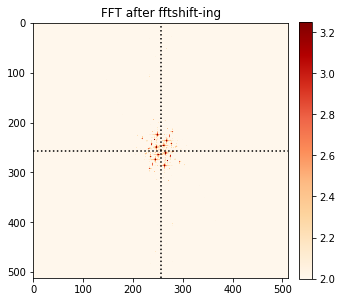

In [8]:
fft_image_raw = np.fft.fft2(stem_image)
fft_image_raw_shifted = np.fft.fftshift(fft_image_raw)
fig, axis = plt.subplots(figsize=(5, 5))
im_handle = axis.imshow(np.log10(np.abs(fft_image_raw_shifted)), 
                        cmap=plt.cm.OrRd, vmin=2, vmax=3.25)
axis.axvline(x=fft_image_raw_shifted.shape[0] // 2, color='k', linestyle=':')
axis.axhline(y=fft_image_raw_shifted.shape[1]// 2, color='k', linestyle=':')
# Add a colorbar
cbar = plt.colorbar(im_handle, ax=axis, fraction=0.046, pad=0.04)
axis.set_title('FFT after fftshift-ing');

## Filtering in the real and frequency domains: 
The atomically resolved image above appears to be quite noisy and the atomic columns are not clearly visible. Below we apply a Gaussian filter to the image both in real and frequency spaces. 

In [9]:
cropped_image = stem_image[:128, :128]
gaus_sigma = 2.0
gaussian_filtered = filters.gaussian(cropped_image, sigma=gaus_sigma)

fft_raw = np.fft.fftshift(np.fft.fft2(cropped_image))
fft_noise_rem = np.fft.fftshift(np.fft.fft2(cropped_image - gaussian_filtered))
fft_gaus_filt = np.fft.fftshift(np.fft.fft2(gaussian_filtered))

## Static visualization

Before we jump to interactive visualizers, let us first visualize the filtered images in real and frequency spaces using the standard plotting techniques:

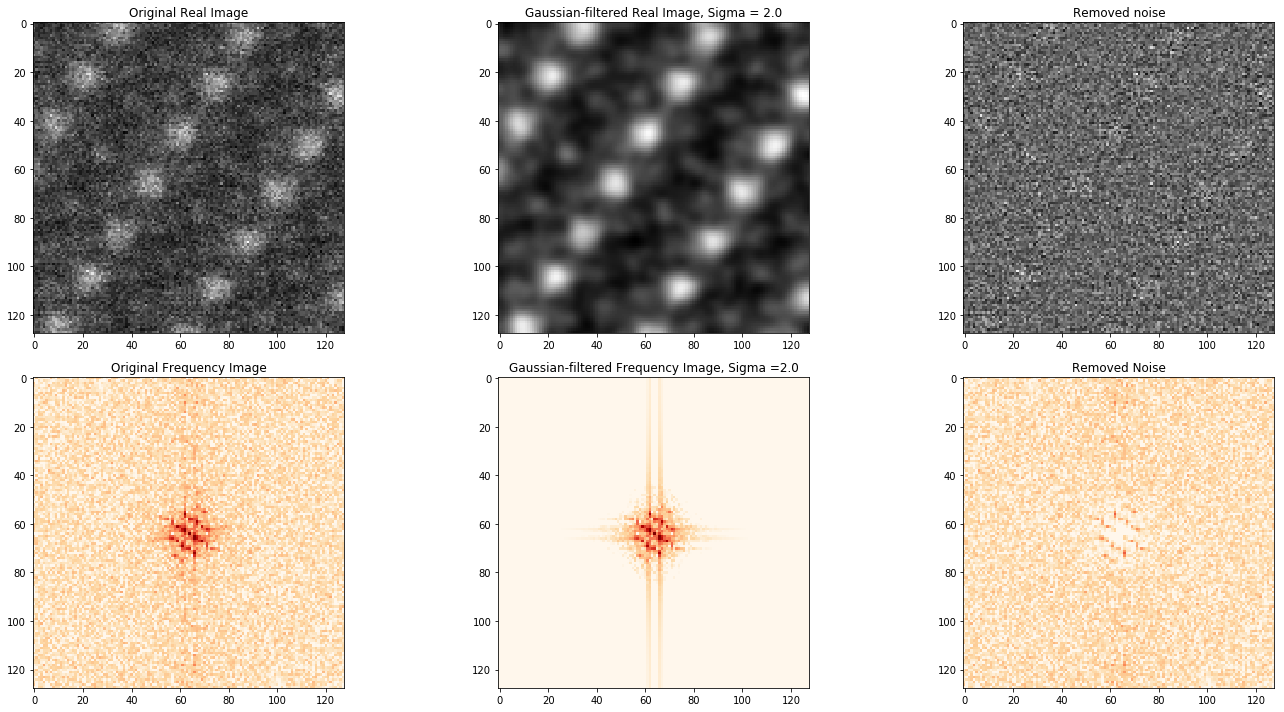

In [6]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
axes[0,0].imshow(cropped_image, cmap='gray')
axes[0,0].set_title('Original Real Image')
axes[0,1].imshow(gaussian_filtered, cmap='gray')
axes[0,1].set_title('Gaussian-filtered Real Image, Sigma = {}'.format(gaus_sigma))
axes[0,2].imshow(cropped_image - gaussian_filtered, cmap='gray')
axes[0,2].set_title('Removed noise');
axes[1,0].imshow(np.log10(np.abs(fft_raw)), cmap=plt.cm.OrRd, vmin=[0.5, 2.5])
axes[1,0].set_title('Original Frequency Image');
axes[1,1].imshow(np.log10(np.abs(fft_gaus_filt)), cmap=plt.cm.OrRd, vmin=[0.5, 2.5])
axes[1,1].set_title('Gaussian-filtered Frequency Image, Sigma ={}'.format(gaus_sigma))
axes[1,2].imshow(np.log10(np.abs(fft_noise_rem)), cmap=plt.cm.OrRd, vmin=[0.5, 2.5])
axes[1,2].set_title('Removed Noise')
fig.tight_layout()

After filtering in freqeuncy space, the center of the image (low-frequency) remains more-or-less the same but the data outside the center (higher spatial frequencies) is drastically reduced in magnitude thereby resulting in a cleaner image. All the noise from the higher frequencies is visible in the removed noise

Thus, the Gaussian filter essentially behaves as a low-pass filter

## Tuning the sigma parameter
Above, we have tried a single value for ``sigma``. Perhaps, it is not the best value for our application. In order to find out the best value, we would need to change the value for ``sigma`` in the cell above and recreate the plots. This can become tedious very quickly, especially when an operation takes multiple parameters (here, we have only one). For such instances, it makes sense to put in a tiny bit of extra effort and turn this plot into an interactive visualizer. 

# Interactive visualizers
There are multiple ways one could go about creating interactive visualizers. We will demonstrate the naive approach followed by a more optimized approach.

## Naive interactive visualizer
The naive approach is to create a function that would recreate the plots as a function of the parameters to the image filter function. All the code in the function, have already been shown above. This completes the first part of the process. We will add the interactivity in the second part. 

In [12]:
def viz_filter_effect(gaus_sigma): 
    gaus_sigma = gaus_sigma
    gaussian_filtered = filters.gaussian(cropped_image, sigma=gaus_sigma)
    fft_raw = np.fft.fftshift(np.fft.fft2(cropped_image))
    fft_gaus_filt = np.fft.fftshift(np.fft.fft2(gaussian_filtered))
    noise_rem = cropped_image - gaussian_filtered
    fft_noise_rem = np.fft.fftshift(np.fft.fft2(noise_rem))
    
    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
    axes[0,0].imshow(cropped_image, cmap='gray')
    axes[0,0].set_title('Original Real Image')
    axes[0,1].imshow(gaussian_filtered, cmap='gray')
    axes[0,1].set_title('Gaussian-filtered Real Image, Sigma = {}'.format(gaus_sigma))
    axes[0,2].imshow(noise_rem, cmap='gray')
    axes[0,2].set_title('Removed noise');
    axes[1,0].imshow(np.log10(np.abs(fft_raw)), cmap=plt.cm.OrRd, vmin=[0.5, 2.5])
    axes[1,0].set_title('Original Frequency Image');
    axes[1,1].imshow(np.log10(np.abs(fft_gaus_filt)), cmap=plt.cm.OrRd, vmin=[0.5, 2.5])
    axes[1,1].set_title('Gaussian-filtered Frequency Image, Sigma ={}'.format(gaus_sigma))
    axes[1,2].imshow(np.log10(np.abs(fft_noise_rem)), cmap=plt.cm.OrRd, vmin=[0.5, 2.5])
    axes[1,2].set_title('Removed Noise')
    fig.tight_layout()

Now, we simply create a slider with `widgets.IntSlider` and use `widgets.interact` to interface the slider with the function. `interact` automatically creates a user interface (UI) control for the graphs.

In the lines below, we:  
1) Define the lower and upper limits of sigma, and label the slider, and  
2) Use interact to link the slider with the function we've defined above and designate the value of `guas_sigma` is set by gaus_slide. 

In [13]:
gaus_slide = widgets.IntSlider(min=0, max=10, description='Sigma', continuous_update=True)
widgets.interact(viz_filter_effect, gaus_sigma=gaus_slide, continuous_update=True);

interactive(children=(IntSlider(value=0, description='Sigma', max=10), Output()), _dom_classes=('widget-intera…

## Recommended method

While the approach above works, it requires that the entire figure comprising six images be replotted each time after the kernel of the Guassian filter is adjusted. Since, all we want is the content within the plots to be updated, this is exactly what we will do. 

The code for this interactive visualizer will be divided into 4 parts:
1. A function that prepares the 2D arrays that will need to be plotted for each of the subplots that need to be updated, as a function of sigma. 
2. The script that will create the figure. 
3. A function that will update the contents of the subplots when the slider value is changed. 
4. The creation of the interactive widgets. 

Normally, all these components would be placed within the same code cell but here, we will break things up for illustrative purposes.

Note that in step 2, we will be saving the handles to each of the subplots into variables. For example:

``image_handle = axis.imshow(....)``

These handles will be necessary in the third part where the contents within the subplots need to be updated. 

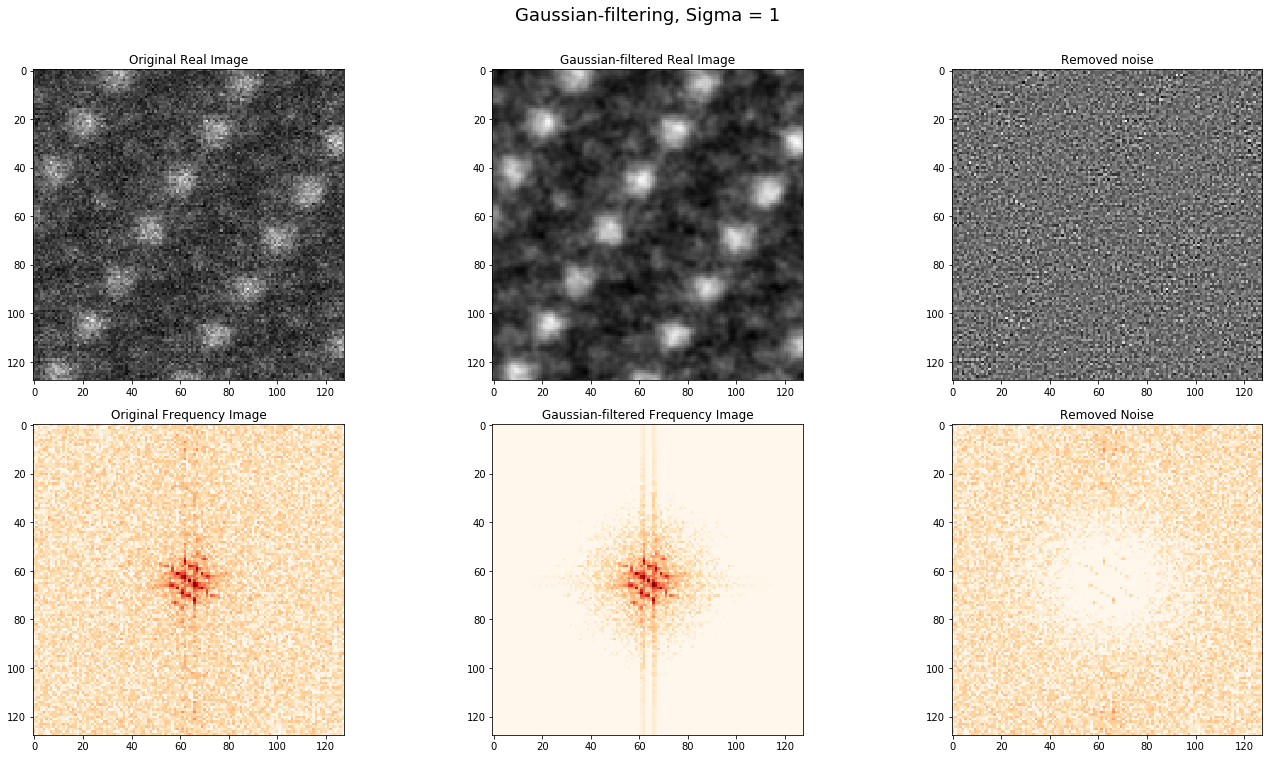

In [14]:
# Part 1 - creating the arrays ready for visualization
# ----------------------------------------------------------------------------
def change_gause_filter(sigma):
    real_filt = filters.gaussian(cropped_image, sigma=sigma)
    real_noise = cropped_image - real_filt
    fft_filt = np.fft.fftshift(np.fft.fft2(real_filt))
    fft_noise = np.fft.fftshift(np.fft.fft2(real_noise))
    return real_filt, real_noise, np.log10(np.abs(fft_filt)), np.log10(np.abs(fft_noise))

# Part 2 - Creating the base figure
# ----------------------------------------------------------------------------
sigma = 1
# Get the images that will change:
real_filt, real_noise, fft_filt, fft_noise = change_gause_filter(sigma)

fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
axes[0,0].imshow(cropped_image, cmap='gray')
axes[0,0].set_title('Original Real Image')
axes[1,0].imshow(np.log10(np.abs(fft_raw)), cmap=plt.cm.OrRd, vmin=[0.5, 2.5])
axes[1,0].set_title('Original Frequency Image');
ih_filt_real = axes[0,1].imshow(real_filt, cmap='gray')
axes[0,1].set_title('Gaussian-filtered Real Image')
ih_noise_real = axes[0,2].imshow(real_noise, cmap='gray')
axes[0,2].set_title('Removed noise');
ih_filt_fft = axes[1,1].imshow(fft_filt, cmap=plt.cm.OrRd, vmin=[0.5, 2.5])
axes[1,1].set_title('Gaussian-filtered Frequency Image')
ih_noise_fft = axes[1,2].imshow(fft_noise, cmap=plt.cm.OrRd, vmin=[0.5, 2.5])
axes[1,2].set_title('Removed Noise')
title_handle = fig.suptitle('Gaussian-filtering, Sigma = {}'.format(sigma), 
                            y=1.05, fontsize=18)
fig.tight_layout()

Next, we define a function that responds to changes in the value of the ``sigma`` slider. It does the following:
* Finds out the value of the parameter
* With the value of ``sigma`` known, it calls the function defined above to get the 2D arrays (filtered image, removed noise, FFTs of the mentioned images) that need to be visualized
* Resets the data associated with the image handles associated with each of the subplots to redraw the contents of the image
* Changes the title of the figure
* Displays the changed figure

Finally, the fourth part calls the ``widgets.interact()`` function just as before

In [15]:
# Part 3:
# ----------------------------------------------------------------------------
def update_plots(sigma):
    real_filt, real_noise, fft_filt, fft_noise = change_gause_filter(sigma)
    for data, img_handle in zip([real_filt, real_noise, fft_filt, fft_noise], 
                                [ih_filt_real, ih_noise_real, ih_filt_fft, ih_noise_fft]):
        img_handle.set_data(data)
    title_handle.set_text('Gaussian-filtering, Sigma = {}'.format(sigma))
    display(fig)

# Part 4:
# ----------------------------------------------------------------------------
widgets.interact(update_plots, sigma=(1, 10, 1));

interactive(children=(IntSlider(value=5, description='sigma', max=10, min=1), Output()), _dom_classes=('widget…

## Review
The example above can be summarized succinctly with the following example where all we want to do is update a single image plot with random numbers each time the slider is changed. 

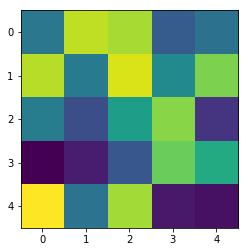

interactive(children=(IntSlider(value=5, description='dummy', max=10, min=1), Output()), _dom_classes=('widget…

In [2]:
fig, axis = plt.subplots()
img_handle = axis.imshow(np.random.rand(5, 5))
def update_plot(dummy):
    img_handle.set_data(np.random.rand(5, 5))
    display(fig)
widgets.interact(update_plot, dummy=(1, 10, 1));

## 1D plots
The same methodology can also be extended to 1D plots as well. Note two changes:
1. ``axis.plot`` generates a list of handles, one per line in the plot. In this case, we only have a single line, so we take the ``[0]`` index of the returned value
2. Contents of line plots need to be updated using ``handle.set_ydata()`` instead of ``handle.set_data()``

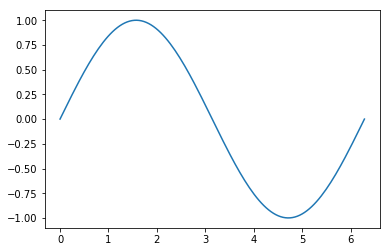

interactive(children=(IntSlider(value=5, description='freq', max=10, min=1), Output()), _dom_classes=('widget-…

In [7]:
t_vec = np.linspace(0, 2*np.pi, 128)

fig, axis = plt.subplots()
plt_handle = axis.plot(t_vec, np.sin(1 * t_vec))[0]
def update_plot(freq):
    plt_handle.set_ydata(np.sin(freq * t_vec))
    display(fig)
widgets.interact(update_plot, freq=(1, 10, 1));